## Synthetic data

This dataset provides a proof of concept comparison of a standard VAE with stochastic decoder and a proposed model with a deterministic decoder. The data consist of 6-bit strings, a probability of each string is given by independent Bernoulli samples with probability of $1$ being $0.8$. For example, a probability of string "110101" is $0.8^4\cdot0.2^2$

To reproduce the models, run the following commands from a terminal:
* `python train.py --config configs/synthetic/U_U.ini --device cuda:0`
* `python train.py --config configs/synthetic/U_T.ini --device cuda:0`
* `python train.py --config configs/synthetic/N_N.ini --device cuda:0`

If you do not have access to GPU, you can specify device as `cpu`.

In [1]:
from itertools import product
from torch.utils.data import DataLoader
from functools import partial
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from scipy.stats import poisson
import torch
%matplotlib inline


from dd_vae.proposals import GaussianProposal
from dd_vae.vae_rnn import VAE_RNN
from dd_vae.utils import collate, StringDataset, prepare_seed

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif'

In [2]:
def create_dataset(ds_size=100000, n=6, p=0.2):
    np.random.seed(777)
    samples = []
    for _ in range(ds_size):
        bits = (np.random.rand(n) > p).astype(int)
        samples.append(''.join(map(str, bits)))
    pd.DataFrame(samples).to_csv(f'data/synthetic/2d_map_{p}.csv.gz', index=None, compression='gzip', header=None)
    if len(np.unique(samples)) != 2**n:
        raise ValueError

In [3]:
# create_dataset() # Run this line if you want to reproduce the dataset

In [4]:
def bin_to_int(x):
    if len(x) == 0:
        return -999
    try:
        return int(x, base=2)
    except:
        return -999

def load_csv(path):
    df = pd.read_csv(path, compression='gzip', dtype='str', header=None)
    return list(df[0].values)

def sample_and_plot(model_path, img_path=None,
                    data_path='data/synthetic/2d_map_0.2.csv.gz',
                    p=0.2, mode='argmax'):
    prepare_seed()
    model = VAE_RNN.load(model_path)

    vocab = model.vocab
    p = 0.2
    dataset = np.unique(load_csv(data_path))
    dataset_hex = [hex(bin_to_int(x)) for x in dataset]
    collate_pad = partial(collate, pad=vocab.pad, return_data=True)
    train_dataset = StringDataset(vocab, dataset)
    train_loader = DataLoader(train_dataset, collate_fn=collate_pad,
                              batch_size=len(dataset))

    batch = next(iter(train_loader))

    dataset = batch[-1]
    z = model.encode(batch[:-1])
    mu, std = model.get_mu_std(z)
    mu = mu.detach().cpu().numpy()
    std = std.detach().cpu().numpy()

    if model.prior == 'gaussian':
        d = 3
    else:
        d = 1
    x = np.linspace(-d, d, 1000)
    y = np.linspace(-d, d, 1000)
    X, Y = np.meshgrid(x, y, indexing='ij')

    torch.manual_seed(777)
    samples = np.array([x for _ in tqdm(range(1000)) for x in
        model.sample(1000, mode=mode, max_len=12)
    ])

    vals = pd.value_counts(samples) / len(samples)

    all_samples = list(set(dataset) | set(samples))

    counts = np.array([
        (vals.get(x, 0), 0.2**(x.count('0'))*0.8**(x.count('1')) if x in dataset else 0)
        for x in all_samples
    ])

    M = (counts[:, 1] + counts[:, 0]) / 2
    P = counts[:, 1]
    Q = counts[:, 0]

    JS = 0.5 * (P*np.log(P/M+1e-9)).sum() + 0.5 * (Q*np.log(Q/M+1e-9)).sum()
    KL = (P * np.log(P/Q+1e-9)).sum()

    if img_path is not None:
        dist = pd.value_counts(samples) / len(samples)

        samples = [
            model.sample(z=torch.tensor((X[i], Y[i])).transpose(0, 1).float(),
                         mode=mode, max_len=8)
            for i in tqdm(range(len(X)))
        ]

        C = np.array([[bin_to_int(x) for x in y] for y in samples])
        K = model.proposal.density(x)[:, None] * model.proposal.density(y)[None, :]

        plt.figure(figsize=(10, 10))
        levels = np.arange(np.min(C), np.max(C)+1)
        plt.contour(X, Y, C+1, levels=levels, colors='k', linewidths=1)
        for i in range(len(dataset)):
            m0, m1 = mu[i]
            s0, s1 = std[i]
            if not isinstance(model.proposal, GaussianProposal):
                plt.plot([m0-d*s0, m0+d*s0, m0+d*s0, m0-d*s0, m0-d*s0],
                         [m1-d*s1, m1-d*s1, m1+d*s1, m1+d*s1, m1-d*s1],
                         'k--', alpha=0.1)
            p = vals.get(dataset[i], 0)
            font = np.clip(200*p, 5, 200)
            plt.text(m0, m1, f"{dataset[i]}\n{p: 0.3f}",
                     color='k', fontsize=font, ha="center", va="center")
            plt.imshow(K, extent=[m0-d*s0, m0+d*s0, m1-d*s1, m1+d*s1],
                       alpha=0.2, cmap=plt.cm.Greys)
        plt.xlim((x[0], x[-1]))
        plt.ylim((y[0], y[-1]))
        plt.title(f'KL={KL : 0.2g}; JS={JS : 0.2g}', fontsize=40)
        plt.tight_layout()
        plt.savefig(img_path+'.png', dpi=250)
        plt.show()

    return {'KL': KL, 'JS': JS}

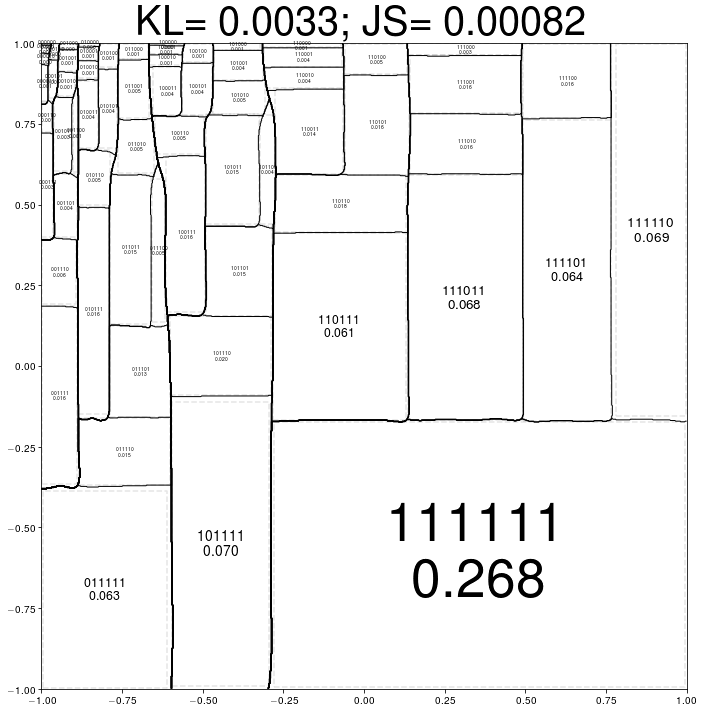

{'KL': 0.0032526485286818816, 'JS': 0.0008154145145564872}

In [5]:
sample_and_plot('models/synthetic/uniform_uniform/checkpoint.pt',
                'images/synthetic/U_U')

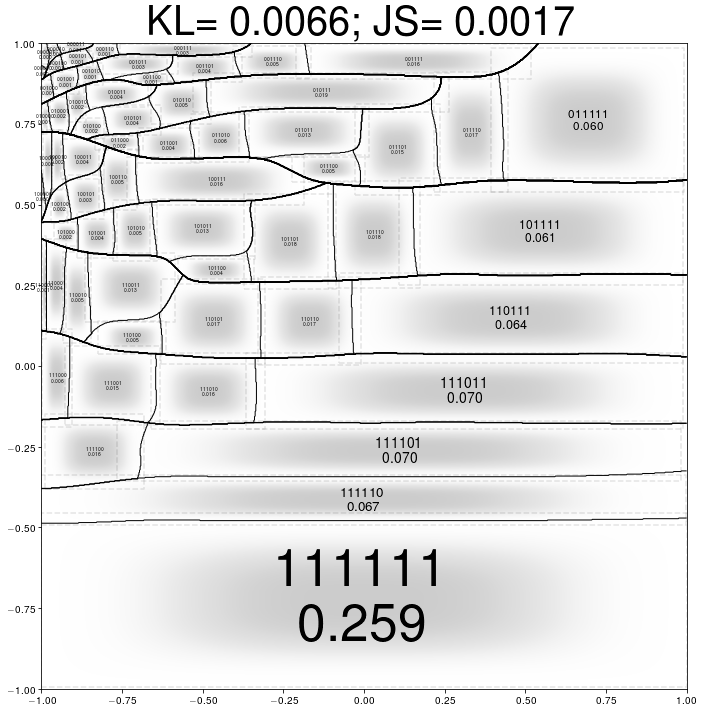

{'KL': 0.006598220360716693, 'JS': 0.0016944043364780083}

In [6]:
sample_and_plot('models/synthetic/uniform_tricube/checkpoint.pt',
                'images/synthetic/U_T')

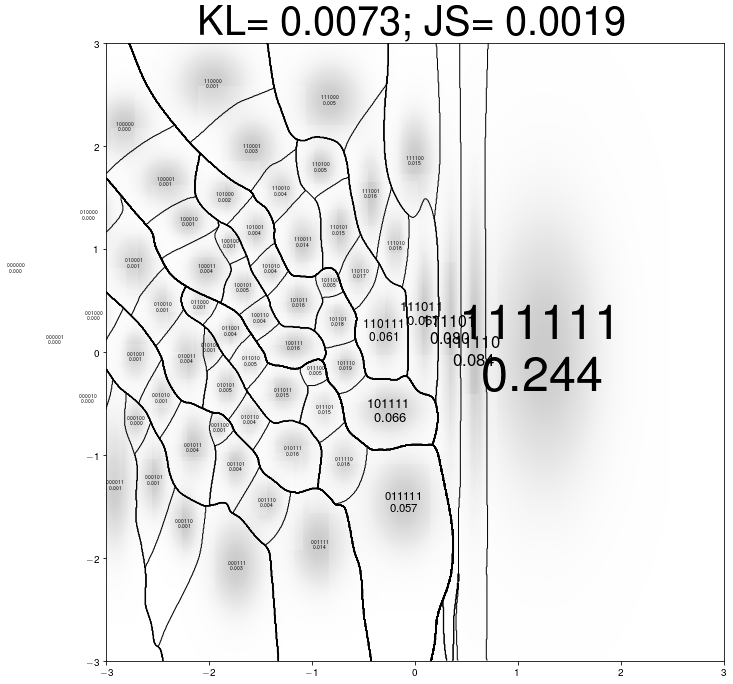

{'KL': 0.007285078585812219, 'JS': 0.0018510054818469722}

In [7]:
sample_and_plot('models/synthetic/normal_normal/checkpoint.pt',
                'images/synthetic/N_N')